## Conformalized Survival Analysis with Right-Censoring

This notebook demonstrates the use of CQR to calibrate lower confidence bounds for survival times under right-censoring.
The methods are implemented in the accompanying "utils" R scripts.

In [1]:
# Load required libraries
suppressMessages(library(tidyverse))
suppressMessages(library(gridExtra))
library(survival)
library(ggsurvfit)
library(grf)

## Generate some survival data

In [2]:
# Generate data from the Log-normal model (Mvt + Heterosc.) of Candes et al. (Table 1)
source("utils_data.R")

# Numbers of features (>= 10)
num_features <- 10

# Sample sizes
num_samples_train <- 2000
num_samples_cal <- 1000
num_samples_test <- 1000

# Set random seet
set.seed(2024)

# Generate training, calibration, and test data
# (including true event and censoring times)
data.train.oracle <- generate_survival_data(num_samples_train, num_features)
data.cal.oracle <- generate_survival_data(num_samples_cal, num_features)
data.test.oracle <- generate_survival_data(num_samples_test, num_features)

# Remove true event and censoring times from the data
data.train <- data.train.oracle |> select(-event_time, -censoring_time)
data.cal <- data.cal.oracle |> select(-event_time, -censoring_time)
data.test <- data.test.oracle |> select(-event_time, -censoring_time)

Let's take a look at the data

In [3]:
# Summarize data
data.train.oracle |>
    summarise(Observations=n(), Events = sum(event), 
              `Mean observed time`=mean(observed_time),
              `Mean observed event time`=mean(observed_time[event]))

Observations,Events,Mean observed time,Mean observed event time
<int>,<int>,<dbl>,<dbl>
2000,583,3.633453,6.061866


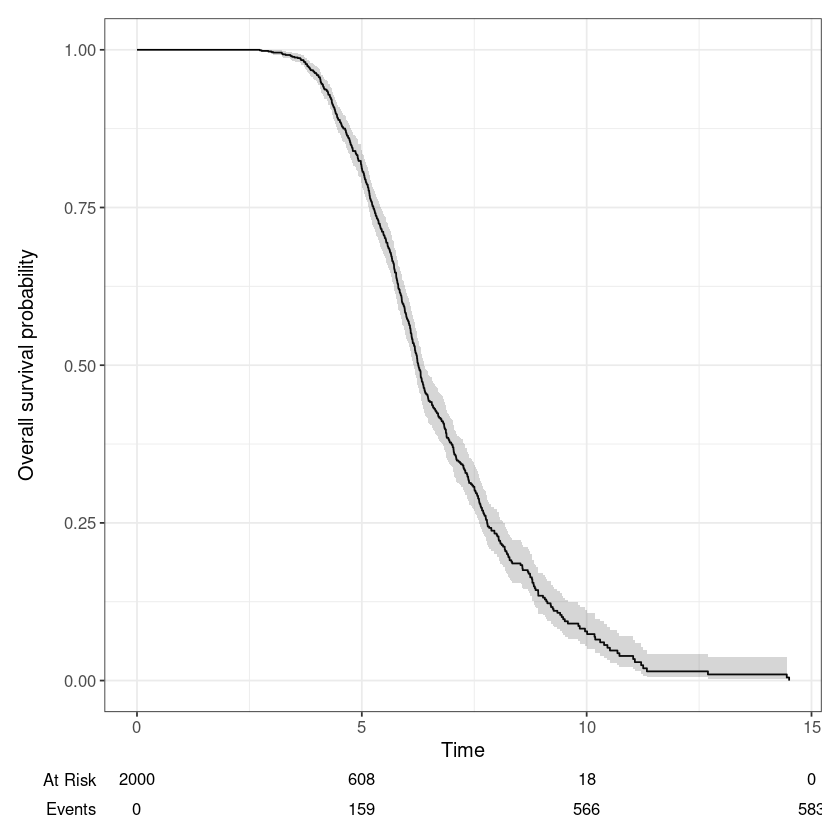

In [4]:
# Kaplan-Meier plot
survfit2(Surv(observed_time, event) ~ 1, data = data.train) |> 
  ggsurvfit() +
  labs(
    x = "Time",
    y = "Overall survival probability"
  ) +
  add_confidence_interval() +
  add_risktable()

## Fit survival model (random forest)

In [5]:
X.train <- as.matrix(select(data.train, starts_with("X")))
Y.train <- data.train$observed_time
D.train <- data.train$event
fit <- grf::survival_forest(X.train, Y.train, D.train)
fit

GRF forest object of type survival_forest 
Number of trees: 1000 
Number of training samples: 2000 
Variable importance: 
    1     2     3     4     5     6     7     8     9    10 
0.665 0.061 0.061 0.021 0.057 0.024 0.028 0.033 0.030 0.020 

## Visualize the model's predictions

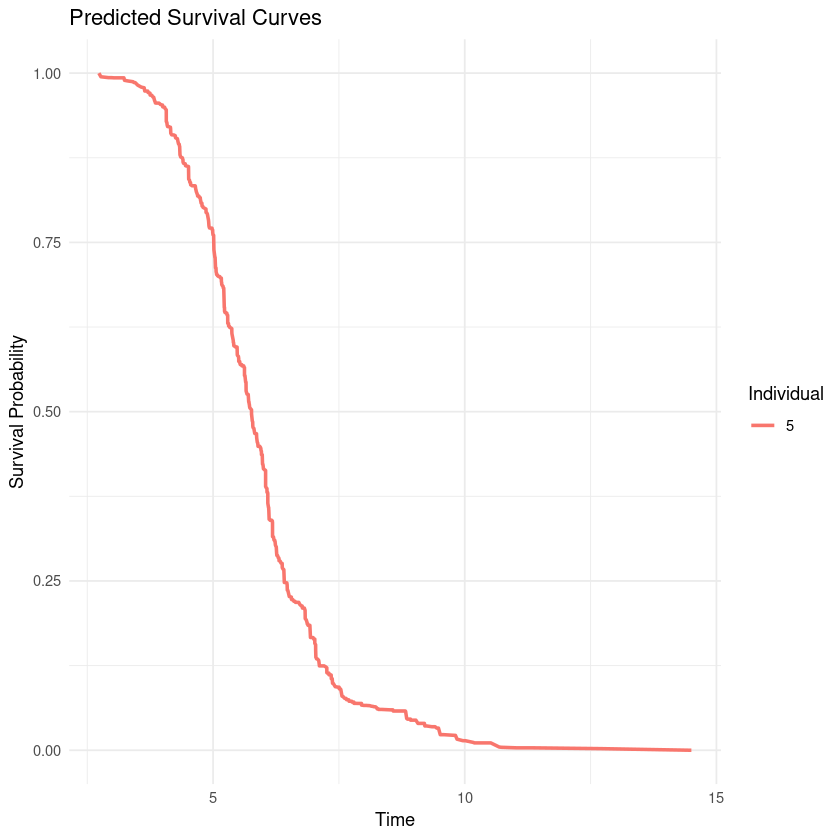

In [6]:
source("utils_plotting.R")
X.cal <- as.matrix(select(data.cal, starts_with("X")))
plot_survival_curves(fit, newX=X.cal, individuals=c(5))

## Predict survival time quantiles

In [7]:
source("utils_survival.R")

percentiles <- c(0.7,0.8,0.9,0.95)
predicted_quantiles <- compute_survival_quantiles(fit, newX=X.cal, 
                                                  percentiles=percentiles) 
                        
predicted_quantiles |> head()

,Q70%,Q80%,Q90%,Q95%
,<dbl>,<dbl>,<dbl>,<dbl>
Individual_1,6.656470,6.083199,5.284906,4.727271
Individual_2,6.405738,5.927030,5.443317,4.797517
Individual_3,6.405738,5.810809,5.324930,4.977450
Individual_4,5.928940,5.509917,4.643188,4.413336
Individual_5,5.105004,4.858350,4.301399,4.036175
Individual_6,5.211886,4.777653,4.363649,3.865265


## Conformalized quantile regression (CQR)

In [8]:
alpha = 0.1

X.cal <- as.matrix(select(data.cal, starts_with("X")))
Y.cal <- data.cal$observed_time
X.test <- as.matrix(select(data.test, starts_with("X")))

pred.cqr <- predict_CQR(X.test, fit, X.cal, Y.cal, alpha)

evaluate_bounds(data.test.oracle$observed_time, 
                pred.cqr$calibrated,
                event_time=data.test.oracle$event_time)

Coverage (observed time),Mean lower bound,Coverage (event time)
<dbl>,<dbl>,<dbl>
0.901,0.5254773,1


Let's compare the uncalibrated and calibrated lower prediction bounds to the true event times for the test data.

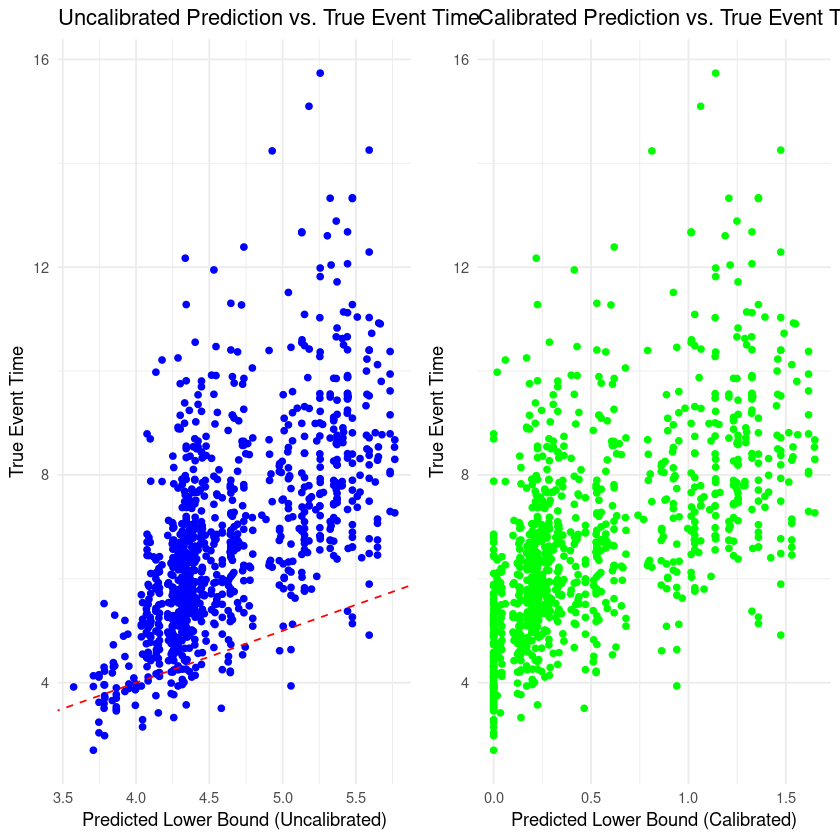

In [9]:
true_time <- data.test.oracle$event_time
predicted_lower_bound_uncalibrated <- pred.cqr$uncalibrated
predicted_lower_bound_calibrated <- pred.cqr$calibrated

# Create data frames for plotting
df_uncalibrated <- data.frame(true_time, 
                              predicted_lower_bound = predicted_lower_bound_uncalibrated, 
                              Type = "Uncalibrated")
df_calibrated <- data.frame(true_time,
                            predicted_lower_bound = predicted_lower_bound_calibrated, 
                            Type = "Calibrated")

# Plot true time vs. predicted lower bound (uncalibrated)
plot_uncalibrated <- ggplot(df_uncalibrated, aes(y = true_time, x = predicted_lower_bound)) +
  geom_point(color = "blue") +
  geom_abline(slope = 1, intercept = 0, linetype = "dashed", color = "red") +
  labs(title = "Uncalibrated Prediction vs. True Event Time",
       y = "True Event Time",
       x = "Predicted Lower Bound (Uncalibrated)") +
  theme_minimal()

# Plot true time vs. predicted lower bound (calibrated)
plot_calibrated <- ggplot(df_calibrated, aes(y = true_time, x = predicted_lower_bound)) +
  geom_point(color = "green") +
  geom_abline(slope = 1, intercept = 0, linetype = "dashed", color = "red") +
  labs(title = "Calibrated Prediction vs. True Event Time",
       y = "True Event Time",
       x = "Predicted Lower Bound (Calibrated)") +
  theme_minimal()

# Arrange the plots side by side
grid.arrange(plot_uncalibrated, plot_calibrated, ncol = 2)

Let's now compare the uncalibrated and calibrated lower prediction bounds to the observed event times for the test data.

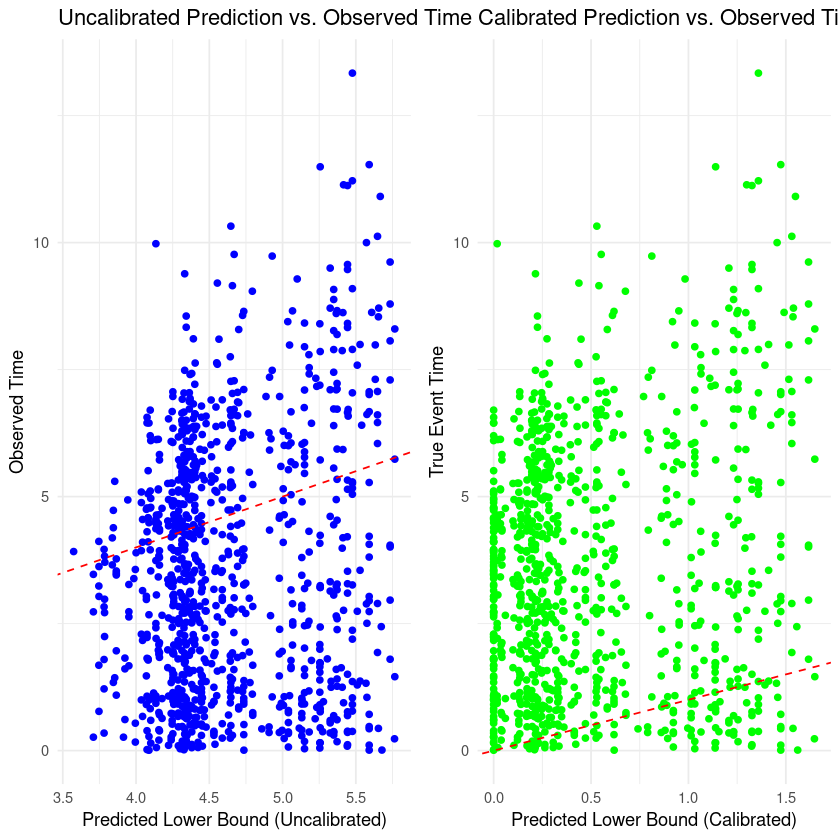

In [10]:
true_time <- data.test.oracle$observed_time
predicted_lower_bound_uncalibrated <- pred.cqr$uncalibrated
predicted_lower_bound_calibrated <- pred.cqr$calibrated

# Create data frames for plotting
df_uncalibrated <- data.frame(true_time, 
                              predicted_lower_bound = predicted_lower_bound_uncalibrated, 
                              Type = "Uncalibrated")
df_calibrated <- data.frame(true_time, 
                            predicted_lower_bound = predicted_lower_bound_calibrated, 
                            Type = "Calibrated")

# Plot true time vs. predicted lower bound (uncalibrated)
plot_uncalibrated <- ggplot(df_uncalibrated, aes(y = true_time, x = predicted_lower_bound)) +
  geom_point(color = "blue") +
  geom_abline(slope = 1, intercept = 0, linetype = "dashed", color = "red") +
  labs(title = "Uncalibrated Prediction vs. Observed Time",
       y = "Observed Time",
       x = "Predicted Lower Bound (Uncalibrated)") +
  theme_minimal()

# Plot true time vs. predicted lower bound (calibrated)
plot_calibrated <- ggplot(df_calibrated, aes(y = true_time, x = predicted_lower_bound)) +
  geom_point(color = "green") +
  geom_abline(slope = 1, intercept = 0, linetype = "dashed", color = "red") +
  labs(title = "Calibrated Prediction vs. Observed Time",
       y = "True Event Time",
       x = "Predicted Lower Bound (Calibrated)") +
  theme_minimal()

# Arrange the plots side by side
grid.arrange(plot_uncalibrated, plot_calibrated, ncol = 2)

This shows the calibrated lower bounds are indeed well calibrated for the observed times (they are lower 90% of the time). 

## Repeated experiments

In [11]:
# Experimental settings
num_samples_train <- 2000
num_samples_cal <- 1000
num_samples_test <- 1000
num_features <- 10
alpha = 0.1

run_experiment <- function(seed) {
    set.seed(seed)
    # Generate training, calibration, and test data
    # (including true event and censoring times)
    data.train.oracle <- generate_survival_data(num_samples_train, num_features)
    data.cal.oracle <- generate_survival_data(num_samples_cal, num_features)
    data.test.oracle <- generate_survival_data(num_samples_test, num_features)

    # Remove true event and censoring times from the data
    data.train <- data.train.oracle |> select(-event_time, -censoring_time)
    data.cal <- data.cal.oracle |> select(-event_time, -censoring_time)
    data.test <- data.test.oracle |> select(-event_time, -censoring_time)

    # Fit survival model on training data
    X.train <- as.matrix(select(data.train, starts_with("X")))
    Y.train <- data.train$observed_time
    D.train <- data.train$event
    fit <- grf::survival_forest(X.train, Y.train, D.train)
    
    # Apply CQR to compute lower prediction intervals  
    X.cal <- as.matrix(select(data.cal, starts_with("X")))
    Y.cal <- data.cal$observed_time
    X.test <- as.matrix(select(data.test, starts_with("X")))
    pred <- predict_CQR(X.test, fit, X.cal, Y.cal, alpha)
    
    # Extract lower bounds
    lower_uncalibrated <- pred$uncalibrated
    lower_calibrated <- pred$calibrated
    
    # Evaluate results
    observed_time = data.test.oracle$observed_time
    true_event_time = data.test.oracle$event_time
    res.uncalibrated <- evaluate_bounds(observed_time, 
                                        lower_uncalibrated,
                                        event_time=true_event_time) |>
        mutate(Method="Uncalibrated")
    res.calibrated <- evaluate_bounds(observed_time, 
                                      lower_calibrated,
                                      event_time=true_event_time) |>
        mutate(Method="CQR")
    
    res <- rbind(res.uncalibrated, res.calibrated) |>
    mutate(Seed=seed) |> select(Seed, everything())
    return(res)
}

In [12]:
# Run one experiment
run_experiment(1)

Seed,Coverage (observed time),Mean lower bound,Coverage (event time),Method
<dbl>,<dbl>,<dbl>,<dbl>,<chr>
1,0.353,4.8238183,0.924,Uncalibrated
1,0.885,0.5981501,1.000,CQR


In [13]:
# Define the seeds for the experiments
seeds <- 1:10

# Initialize a list to store results
results <- list()

# Total number of seeds
n <- length(seeds)

# Loop over the seeds
for (i in seq_along(seeds)) {
  seed <- seeds[i]
  # Run the experiment and store the result
  results[[i]] <- run_experiment(seed)
}

# Combine all tibbles into a single tibble
combined_results <- bind_rows(results)

Plot results from experiments

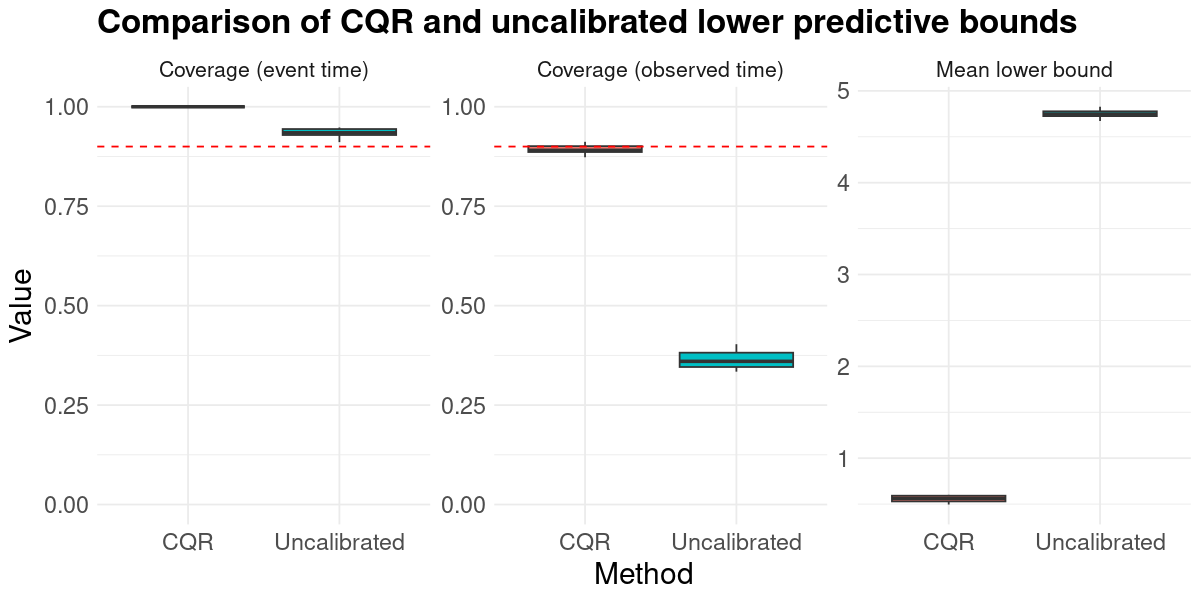

In [14]:
df <- combined_results

# Reshape the data for ggplot2
df_long <- df %>%
  pivot_longer(cols = c(`Coverage (observed time)`,
                        `Mean lower bound`, 
                        `Coverage (event time)`),
               names_to = "Metric",
               values_to = "Value")

# Set the plot size for Jupyter
options(repr.plot.width = 10, repr.plot.height = 5)
        
# Create the plot
ggplot(df_long, aes(x = Method, y = Value, fill = Method)) +
  geom_boxplot() +
  geom_hline(data = df_long %>% filter(startsWith(Metric, "Coverage")), 
             aes(yintercept = 0.9), 
             linetype = "dashed", color = "red") +
  geom_hline(data = df_long %>% filter(startsWith(Metric, "Coverage")), 
             aes(yintercept = 1), 
             linetype = "dashed", alpha=0) +
  geom_hline(data = df_long %>% filter(startsWith(Metric, "Coverage")), 
             aes(yintercept = 0), 
             linetype = "dashed", alpha=0) +
  facet_wrap(~Metric, scales = "free_y") +
  theme_minimal() +
  labs(title = "Comparison of CQR and uncalibrated lower predictive bounds",
       x = "Method",
       y = "Value") +
  theme(
    text = element_text(size = 16),             # Increase all text elements
    axis.title = element_text(size = 18),       # Increase axis titles
    axis.text = element_text(size = 14),        # Increase axis text
    legend.position = "none",                   # Remove legend
    plot.title = element_text(size = 20, face = "bold") # Increase and bold plot title
  )

The results show that the CQR lower bounds are well-calibrated for the observed times, but they are way too low for the true event times.
The uncalibrated predicted lower bounds output by the random forest model do not have any guarantees in theory, but they perform better here for the true event times.